In [1]:
import fnmatch, re, os
import json

def parametrizedFileSelection(fileDirectory, fileArguments):
    files = []
    
    for k,v in fileArgs.items():
        if type(v) is not list:
            fileArgs[k] = [v]
        
    for file in os.listdir(fileDirectory):
        for key in fileArguments:
            match = False
            for value in fileArguments[key]:
                expression = key + "=" + str(value)
                if expression + ',' in file or expression + '_' in file:
                    match = True
            if match == False:
                break
    
        if match == True:
            files.append(file)
        
    return files


# Experiment factors

- filename
- nWorkers
- voterSeed
- comDet
- assignment
- withBoundary (false si order based)
- distType (close/far)
- minDist 

Pour un même nombre de worker on fait varier la seed (cas order based)

In [2]:
import pandas as pd

fileDirectory = "../outputs/facebook_combined_vobws/"

# fileArgs = { "nWorkers": 10, "voterSeed": 0, "minDist": "1"}
fileArgs = { "nWorkers": 807 }      
files = parametrizedFileSelection(fileDirectory, fileArgs)

filesData = []

for file in files:
    with open(fileDirectory + file) as json_file:
        data = json.load(json_file)
        filesData.append(data)        
       # print(len(data['candidates'][0]) ,"-", len(data['candidates']), data['candidates'])
df = pd.DataFrame(filesData)

df.head()

,filefullname,filename,filepath,imgDirPath,comDet,imgDiamPath,imgRadPath,imgNpCPath,diameter,diameters,...,imgCDPath,imgInCDPath,imgWpCPath,workerComDistances,workerDistances,workersPerCommunity,distType,minDist,cliqueImgPath,candidates
0,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 78, 0, 0, 0, 0, 0, 0, 0], '...","{'self': [0, 807, 0, 0, 0, 0, 0, 0, 0, 0], 'sa...",16,close,1,graphs/img/facebook_combined/facebook_combined...,"[[V2142, V2266, V2611, V2220, V1962, V2233, V1..."
1,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 78, 0, 0, 0, 0, 0, 0, 0], '...","{'self': [0, 807, 0, 0, 0, 0, 0, 0, 0, 0], 'sa...",16,close,2,graphs/img/facebook_combined/facebook_combined...,"[[V1405, V1561, V1460, V1585, V1266, V1286, V1..."
2,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 78, 0, 0, 0, 0, 0, 0, 0], '...","{'self': [0, 807, 0, 0, 0, 0, 0, 0, 0, 0], 'sa...",16,close,3,graphs/img/facebook_combined/facebook_combined...,"[[V414, V566, V1719, V1825, V1494, V1307, V180..."
3,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 78, 0, 0, 0, 0, 0, 0, 0], '...","{'self': [0, 807, 0, 0, 0, 0, 0, 0, 0, 0], 'sa...",16,close,4,graphs/img/facebook_combined/facebook_combined...,"[[V567, V3437, V1719, V559, V360, V414, V591, ..."
4,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 78, 0, 0, 0, 0, 0, 0, 0], '...","{'self': [0, 807, 0, 0, 0, 0, 0, 0, 0, 0], 'sa...",16,far,4,graphs/img/facebook_combined/facebook_combined...,[Timeout]


(array([65.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  2.]),
 array([1.000000e+00, 6.714450e+04, 1.342880e+05, 2.014315e+05,
        2.685750e+05, 3.357185e+05, 4.028620e+05, 4.700055e+05,
        5.371490e+05, 6.042925e+05, 6.714360e+05]),
 <BarContainer object of 10 artists>)

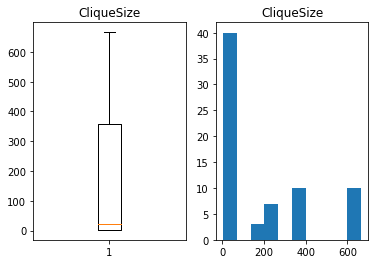

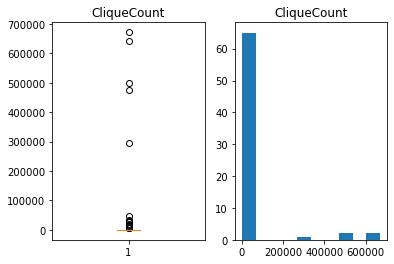

In [3]:
import matplotlib.pyplot as plt

largestCliqueSize = lambda x : len(x[0])
largestCliqueCount = lambda x : len(x)


largestCliqueSizeData = df["candidates"].apply(largestCliqueSize)
largestCliqueCountData = df["candidates"].apply(largestCliqueCount)


fig1, ax1 = plt.subplots(ncols=2)
ax1[0].set_title('CliqueSize')
ax1[0].boxplot(largestCliqueSizeData)
ax1[1].set_title('CliqueSize')
ax1[1].hist(largestCliqueSizeData)

fig2, ax2 = plt.subplots(ncols=2)
ax2[0].set_title('CliqueCount')
ax2[0].boxplot(largestCliqueCountData)
ax2[1].set_title('CliqueCount')
ax2[1].hist(largestCliqueCountData)

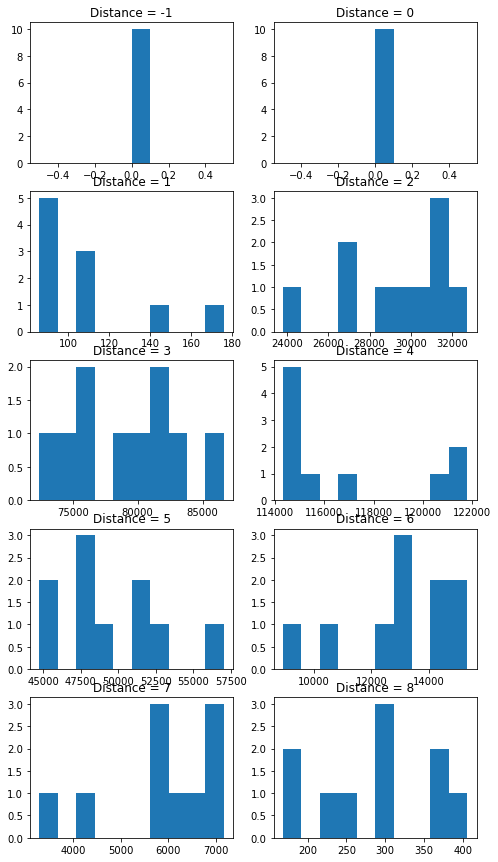

In [11]:
from scipy import stats
import numpy as np

otherWorkersDistance = lambda x : x["other"]

data = []

for seed in range(0,10):
    filterOnSeed = df.where(df["voterSeed"] == seed).dropna()
    otherWorkersDistanceData = filterOnSeed.head(1)["workerDistances"].apply(otherWorkersDistance)
    data.append(otherWorkersDistanceData.tolist()[0])

newData = np.zeros((10,10), dtype=int)
for x,l in enumerate(data):
    for y in range(0,len(l)):
        newData[x][y] = l[y]


df2 = pd.DataFrame(newData, columns=range(-1,9))

df2 = df2.apply(lambda x : x//2) #remove bidirectionnal links

fig1, ax1 = plt.subplots(nrows=5, ncols=2, figsize=(4*2,3*5))
for index, column in enumerate(df2.columns):
    ax1[index//2][index%2].set_title('Distance = ' + str(column))
    ax1[index//2][index%2].hist(df2[column])

# shapiro_test = stats.shapiro(x)

# print(shapiro_test)
# print(shapiro_test.statistic)
# print(shapiro_test.pvalue)